## Benchmark 4: oneshot naive model cross validation
Major consideration here is, do we score one time point from the forecast period or all four? Thinking we should probably do both. Scoring one point will give us the best comparison to the current public leaderboard. But the actual model we need to build will be predicting four future timepoints.
1. [Abbreviations & definitions](#abbrevations_definitions)
2. [Load & inspect](#load_inspect)
3. [Cross validation SMAPE](#cross_validation_smape)

In [6]:
# Add parent directory to path to allow import of config.py
import sys
sys.path.append('..')
import config as conf

import numpy as np
import pandas as pd

print(f'Python: {sys.version}')
print()
print(f'Numpy {np.__version__}')
print(f'Pandas {pd.__version__}')

Python: 3.10.0 | packaged by conda-forge | (default, Nov 20 2021, 02:24:10) [GCC 9.4.0]

Numpy 1.23.5
Pandas 1.4.3


<a name="abbreviations_definitions"></a>
### 1. Abbreviations & definitions
+ MBD: microbusiness density
+ MBC: microbusiness count
+ OLS: ordinary least squares
+ Model order: number of past timepoints used as input data for model training
+ Origin (forecast origin): last known point in the input data
+ Horizon (forecast horizon): number of future data points predicted by the model
+ SMAPE: Symmetric mean absolute percentage error

In [7]:
model_order = 4
forecast_horizon = 4

<a name="load_inspect"></a>
### 2. Load & inspect

In [8]:
# Load cross validation data
input_file = f'{conf.PARSED_DATA_PATH}/order{model_order}_horizon{forecast_horizon}.npy'
parsed_data = np.load(input_file)

print(f'Shape: {parsed_data.shape}')

Shape: (100320, 2, 4, 4)


OK this, numpy array is structured as follows:
+ **First dimension**: data elements
+ **Second dimension**: input, forecast block halves
+ **Third dimension**: rows
+ **Fourth dimension**: columns: *cfips, first_day_of_month, microbusiness_density, active*

Let's start by defining some helper functions so that we can easily loop over multiple samples, calculating training and validation scores for each.

<a name="cross_validation_SMAPE"></a>
### 3. Cross validation SMAPE

In [9]:
def sample_parsed_data(
    parsed_data,
    training_fraction      
):
    '''Randomly select fraction of data for training, keep the rest for validation'''

    # Calculate sample sizes
    training_sample_size = int(len(parsed_data) * training_fraction)

    # Generate list of random indices for training sample
    random_training_indices = np.random.choice(parsed_data.shape[0], training_sample_size, replace=False)

    # Use random indices to extract training sample from parsed data
    training_sample = parsed_data[random_training_indices]

    # Loop on parsed_data indices, if index was not in random validation sample
    # add that data to the validation sample
    validation_sample = []

    for i in range(len(parsed_data)):
        if i not in random_training_indices:
            validation_sample.append(parsed_data[i])

    # Convert to numpy array
    validation_sample = np.array(validation_sample)

    return training_sample, validation_sample

In [10]:
def two_point_smape(actual, forecast):

    # If SMAPE denominator is zero set SMAPE to zero
    if actual == 0 and forecast == 0:
        return 0

    # Calculate smape for forecast
    smape = abs(forecast - actual) / ((abs(actual) + abs(forecast)) / 2)
    
    return smape

In [11]:
def naive_model_smape_score(sample):

    # Holders SMAPE for forecast horizon of one and four
    one_point_smape_values = []
    four_point_smape_values = []

    for block in sample:

        # Get true forecast values
        forecast_value = block[0,-1,2]

        # Get the target values
        actual_values = block[1,0:,2]

        # Holder for this sample's SMAPE values
        smape_values = []

        # Calculate SMAPE value for forecast
        for actual_value in actual_values:
            smape_values.append(two_point_smape(actual_value, forecast_value))

        # Collect this sample's SMAPE values
        one_point_smape_values.append(smape_values[0])
        four_point_smape_values.extend(smape_values)

    # Calculate SMAPE score for this block
    one_point_smape_score = (100/len(one_point_smape_values)) * sum(one_point_smape_values)
    four_point_smape_score = (100/len(four_point_smape_values)) * sum(four_point_smape_values)

    return one_point_smape_score, four_point_smape_score

In [17]:
def crossvalidation_smape(parsed_data, folds, training_fraction):
    '''Generates random training-validation split, forecasts and calculates SMAPE score
    folds number of times, returns dict of SMAPE scores for forecast horizon of one and four'''

    # Holder for results
    smape_scores = {
        'one_point_training': [],
        'one_point_validation': [],
        'four_point_training': [],
        'four_point_validation': []
    }

    print(f'Training subset size: {int(len(parsed_data) * training_fraction)}')

    # Loop on folds
    for i in range(folds):

        # Get random training and validation samples
        training_sample, validation_sample = sample_parsed_data(
            parsed_data,
            training_fraction
        )

        # Forecast on and score training and validation subsets
        one_point_training_smape, four_point_training_smape = naive_model_smape_score(training_sample)
        one_point_validation_smape, four_point_validation_smape = naive_model_smape_score(validation_sample)

        # Collect scores
        smape_scores['one_point_training'].append(one_point_training_smape)
        smape_scores['one_point_validation'].append(one_point_validation_smape)
        smape_scores['four_point_training'].append(four_point_training_smape)
        smape_scores['four_point_validation'].append(four_point_validation_smape)

    # Convert to pandas dataframe
    smape_scores_df = pd.DataFrame(smape_scores)

    return smape_scores_df

In [18]:
folds = 10
training_fraction = 0.7

smape_scores_df = crossvalidation_smape(parsed_data, folds, training_fraction)

Training subset size: 70224


<a name="results"></a>
### 4. Results

In [19]:
smape_scores_df.head()

,one_point_training,one_point_validation,four_point_training,four_point_validation
0,1.787873,1.742121,3.088988,3.072394
1,1.774454,1.773430,3.085986,3.079400
2,1.772632,1.777682,3.089566,3.071047
3,1.794215,1.727323,3.098748,3.049622
4,1.785224,1.748302,3.090177,3.069621


In [20]:
smape_scores_df.describe()

,one_point_training,one_point_validation,four_point_training,four_point_validation
count,10.000000,10.000000,10.000000,10.000000
mean,1.776108,1.769572,3.085198,3.081238
std,0.009611,0.022426,0.010184,0.023763
min,1.766663,1.727323,3.066858,3.049622
25%,1.768438,1.754463,3.084864,3.069977
50%,1.773543,1.775556,3.088371,3.073835
75%,1.782583,1.787469,3.090024,3.082018
max,1.794215,1.791611,3.098748,3.124032


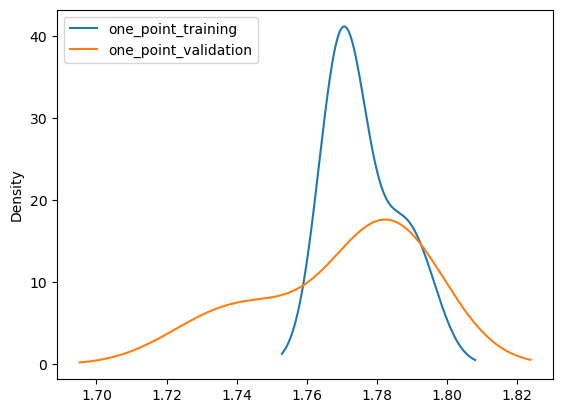

In [21]:
one_point_smape_scores_df = smape_scores_df[['one_point_training', 'one_point_validation']]
ax = one_point_smape_scores_df.plot.kde(xlabel = 'SMAPE')

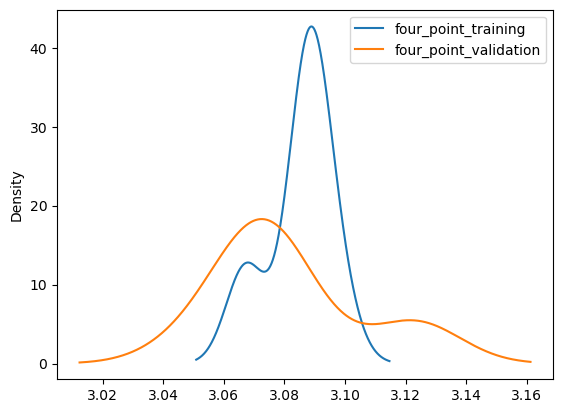

In [22]:
one_point_smape_scores_df = smape_scores_df[['four_point_training', 'four_point_validation']]
ax = one_point_smape_scores_df.plot.kde(xlabel = 'SMAPE')

OK - so cross validation SMAPE scores are quite a bit higher than the public leaderboard score using the same 'model'. I also notice that the four point SMAPE is much larger than the one point SMAPE. Will have to come back and look at this with fresh eyes to see if this is expected behavior or if there is a problem with my calculations. But it could just be that naive, 'carry-forward' predictions get worse the farther forward they are carried. 

Anyway that's the first pass at it complete.

**REVISIT** Double checked sampling and scoring logic. Looks good, ran 100 fold cross validation. One point SMAPE is still much worse than the actual public leaderboard score for this model. Maybe November is just a really lucky test sample for this model - i.e. not much changed that month. Come to think of it, we could calculate how likely a SMAPE equal to or better than that observed on the leaderboard is using the mean and standard deviation from our cross validation experiment.

In [23]:
from statistics import NormalDist

one_point_training_mean = smape_scores_df['one_point_training'].describe()['mean']
one_point_training_std = smape_scores_df['one_point_training'].describe()['std']

print(f'Mean: {one_point_training_mean}')
print(f'Standard deviation: {one_point_training_std}')

leaderboard_score_probability = NormalDist(mu=one_point_training_mean, sigma=one_point_training_std).cdf(1.0936)
print(f'Probability of SMAPE <= 1.0936: {leaderboard_score_probability}')

Mean: 1.7761080734567323
Standard deviation: 0.009611201312863507
Probability of SMAPE <= 1.0936: 0.0


Yikes - this is kind of bad news. It means that either we are doing something wrong in our sampling & SMAPE calculations and inflating our SMAPE values, or the current public leaderboard is being scored against a very 'weird' (and easy for the naive model) sample. Let's try one more thing and repeat this experiment with a small sample size. Reasoning here is on the public leaderboard each county gets scored once (3,135 data points) whereas our training samples are around 70,000 points each. Seems more likely to get extreme values in small samples.

In [24]:
folds = 10
training_fraction = 0.03135 # Choose training fraction to result in ~3135 datapoints

smape_scores_df = crossvalidation_smape(parsed_data, folds, training_fraction)

Training subset size: 3145


In [25]:
smape_scores_df.describe()

,one_point_training,one_point_validation,four_point_training,four_point_validation
count,10.000000,10.000000,10.000000,10.000000
mean,1.804489,1.773165,3.098963,3.083526
std,0.111205,0.003599,0.094236,0.003050
min,1.641027,1.767208,2.975491,3.077569
25%,1.723381,1.770340,3.040814,3.081807
50%,1.780004,1.773958,3.092002,3.083751
75%,1.891773,1.775790,3.152087,3.085408
max,1.988550,1.778456,3.283027,3.087522


Note the difference in standard deviation between training (small) and validation (large) samples!

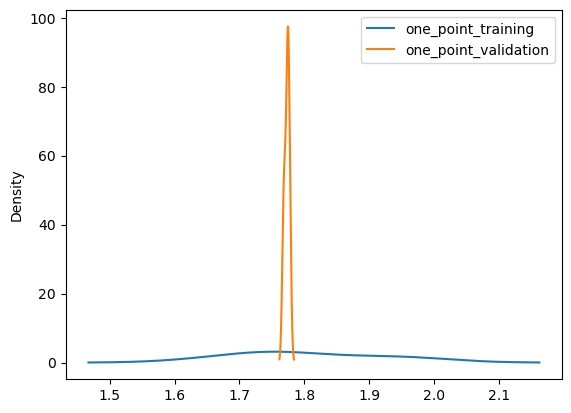

In [26]:
smape_scores_df = smape_scores_df[['one_point_training', 'one_point_validation']]
ax = smape_scores_df.plot.kde(xlabel = 'SMAPE')

In [28]:
training_mean = smape_scores_df['one_point_training'].describe()['mean']
training_std = smape_scores_df['one_point_training'].describe()['std']

print(f'Mean: {training_mean}')
print(f'Standard deviation: {training_std}')

leaderboard_score_probability = NormalDist(mu=training_mean, sigma=training_std).cdf(1.0936)
print(f'Probability of SMAPE <= 1.0936: {leaderboard_score_probability}')

Mean: 1.8044893422014152
Standard deviation: 0.11120452957917003
Probability of SMAPE <= 1.0936: 8.15285616795336e-11


It's still a vanishingly small probability of getting a sample from the training data on which the naive, 'carry-forward' model does as well or better on that it does on the current leaderboard test set. This makes things a bit difficult - i.e. we can't put much stock in our leaderboard score! Other forecasting methods might do better. But, I worry that if the leaderboard test set is so different from the rest of the dataset we will hurt our generalizability chasing a good public leaderboard score. If we tune everything to do as well as possible on the public leaderboard test set, we might get destroyed on the private leaderboard when new data shows up. Good news is, the public leaderboard test data for November data should be published soon.

**REVISIT** OK, I thought about this some more and I have an idea about what is going on here. Two points to remember 1) the dataset has some serious anomalies - i.e. dates where many/all counties experience uncharacteristically large changes in MBD. And 2) The timepoints are not really independent across counties. Just thinking about it, every county is subject to at least some of the same external forces, examples: covid, fed interest rates, stock market trends, national news etc.

With those two points in mind, let's assume that November 2022 (the timepoint used for scoring on the public leaderboard) is not an anomaly. Then think about how we are sampling our data blocks. We are taking a shotgun approach and grabbing a bunch of random time points for the training-validation split and likely including some anomalous timepoints. This inflates the sample SMAPE relative to the leaderboard SMAPE. Rather than scoring one timepoint and doing terribly if it's and anomaly and OK if it's not, we are taking some anomalous points and some nonanomalous points and as a result doing somewhat terribly every time. As a quick kludge experiment, let's try drawing only one timepoint for training and one timepoint for validation from each fold. We will also up the number of folds so that in the end, we are scoring the same total number of datapoints as before - i.e. scoring one datapoint 3135 * 100 times rather than 3135 datapoints 100 times. I expect we will get some very good results and some very bad results, with our observed leaderboard score being much less unlikely.

In [29]:
def naive_model_smape_score_2(sample, scored_timepoints):
    one_point_smape_values = []
    four_point_smape_values = []

    # Score only the first n timepoints from the sample
    for block in sample[:scored_timepoints]:

        # Get the last microbusiness_density value from the input block
        # and use this as our constant forecast
        forecast_value = block[0,-1,2]

        # Get the target values
        actual_values = block[1,0:,2]

        # Score the predictions
        smape_values = []

        for actual_value in actual_values:
            smape_values.append(two_point_smape(actual_value, forecast_value))

        one_point_smape_values.append(smape_values[0])
        four_point_smape_values.extend(smape_values)

    one_point_smape_score = (100/len(one_point_smape_values)) * sum(one_point_smape_values)
    four_point_smape_score = (100/len(four_point_smape_values)) * sum(four_point_smape_values)

    return one_point_smape_score, four_point_smape_score

In [35]:
smape_scores = {
    'one_point_training': [],
    'one_point_validation': [],
    'four_point_training': [],
    'four_point_validation': []
}

training_fraction = 0.5 # Fraction does not really matter for this experiment, 
                        # we are only taking the first element from training and validation subsets
scored_timepoints = 1
folds = 10 * 3135

for i in range(folds):

    training_sample, validation_sample = sample_parsed_data(
        parsed_data,
        training_fraction
    )

    one_point_training_smape, four_point_training_smape = naive_model_smape_score_2(training_sample, scored_timepoints)
    one_point_validation_smape, four_point_validation_smape = naive_model_smape_score_2(validation_sample, scored_timepoints)

    smape_scores['one_point_training'].append(one_point_training_smape)
    smape_scores['one_point_validation'].append(one_point_validation_smape)
    smape_scores['four_point_training'].append(four_point_training_smape)
    smape_scores['four_point_validation'].append(four_point_validation_smape)

smape_scores_df = pd.DataFrame(smape_scores)


In [34]:
smape_scores_df.describe()

,one_point_training,one_point_validation,four_point_training,four_point_validation
count,10.000000,10.000000,10.000000,10.000000
mean,2.871596,0.875252,5.121263,1.599712
std,3.048895,0.922955,6.564313,0.543418
min,0.318983,0.000000,0.295006,1.372535
25%,0.642856,0.000000,2.885374,1.419457
50%,1.351732,0.809859,3.310993,1.419457
75%,4.233407,1.727478,4.909805,1.477306
max,9.523807,2.256245,23.179615,3.142305


In [32]:
one_point_training_mean = smape_scores_df['one_point_training'].describe()['mean']
one_point_training_std = smape_scores_df['one_point_training'].describe()['std']

print(f'Mean: {one_point_training_mean}')
print(f'Standard deviation: {one_point_training_std}')

leaderboard_score_probability = NormalDist(mu=one_point_training_mean, sigma=one_point_training_std).cdf(1.0936)
print(f'Probability of SMAPE <= 1.0936: {leaderboard_score_probability}')

Mean: 2.871595772702466
Standard deviation: 3.04889523757781
Probability of SMAPE <= 1.0936: 0.27989257422357444


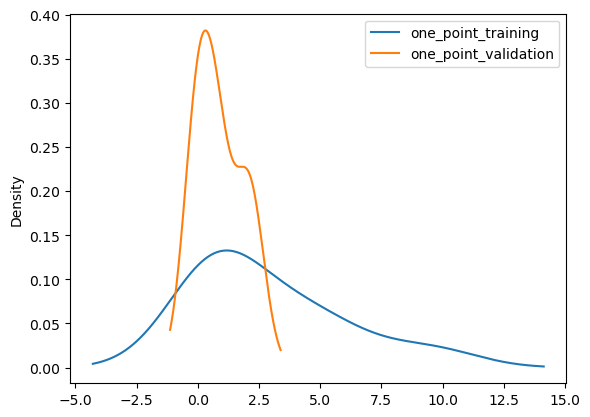

In [33]:
one_point_smape_scores_df = smape_scores_df[['one_point_training', 'one_point_validation']]
ax = one_point_smape_scores_df.plot.kde(xlabel = 'SMAPE')

OK - completely different results. As expected, we have some very good scores and some very bad scores relative to our leaderboard score, which now does not look unlikely at all. What did we learn? When scoring predictions, don't aggregate across multiple forecast origins. I would call this done, but looking at the result closely, we seem to have uncovered or caused a new problem. Even with a 50:50 training:validation split, the training scores have a higher mean and larger spread. Not immediately sure why that should be the case. Seems like bug, we should definitely fix/explain it before moving on...

<a name="TODO"></a>
### 5. TODO
1. <s>Check cross validation parsing for frameshift/indexing errors.</s>
2. Refactor SMAPE scoring function to take the number of timepoints to score from the training and test samples as an argument. Set sensible defaults.
3. Refactor helper functions into module.
4. Parallelize sampling over processors using python multiprocessing module.